In [1]:
#Import necessary libaries
import re
import numpy as np
import pandas as pd
from pprint import pprint
import string

#To perform nlp and LDA operation
import gensim
from gensim.corpora import Dictionary
from gensim.models import ldamodel, CoherenceModel
from gensim.utils import simple_preprocess


#For visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline


#for stopwords
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
# for lemmatization
import spacy

import sklearn.utils

In [2]:
#Load the data
df = pd.DataFrame(pd.read_csv('glassdoor_review.csv'), )

In [3]:
#Explore the data
df.head()

,Unnamed: 0,company_code,company_name,review
0,0,1,Intel,"""Good""\n ['Good ,work life, very good, perks,g..."
1,1,1,Intel,"""Physical design engineer""\n ['Work life balan..."
2,2,1,Intel,"""Great place ro work""\n ['Great place to work,..."
3,3,1,Intel,"""Friendly working culture""\n ['1.Helps person ..."
4,4,1,Intel,"""Working style""\n ['Flexibility, opportunity t..."


In [4]:
#Renaming the coumn 'Unnamed: 0' to 'Document_No'
df = df.rename(columns={'Unnamed: 0': 'Document_No'})

In [5]:
#Shuffle the rows
# np.random.seed(41)
# df1 = df.reindex(np.random.permutation(df.index))
# df1.reset_index(drop=True, inplace=True)
# df1 = sklearn.utils.shuffle(df,random_state=21)

In [6]:
# #Reset
# df1.reset_index(drop=True, inplace=True)
# df1.head()

In [7]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [8]:
#Function for preprocessing data
#Removes any hyerlink
#Removes punctuations
#Remove any digits
#Convert all the Uppercase words to lowercase, so that two words are not consider as unique
#Removes stop words
#Perform lemmatization, i.e will find the root words 
def clean_text(text, remove_stopwords = True, lemmatization = True):
    
    # Convert words to lower case
    text = text.lower()
    lemmatizer = WordNetLemmatizer()
    #w_tokenizer = word_tokenize()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', ' ', text,  
                  flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', ' ', text) 
    text = re.sub(r'[_"\--;%()|+&=*%.,!?:#$@\[\]/<>]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\d+\S\d+\S\d+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\[[0-9]*\]',' ',text)
#     text = re.sub(r'\s+',' ',text)
    text = re.sub(r"\b[a-z]\b", " ", text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english") + list(string.punctuation))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
    
    if lemmatization:
        text = [lemmatizer.lemmatize(w) for w in word_tokenize(text)]
        text = " ".join(text)

    return text

In [9]:
#Calling clean_text() function to get the preprocessed data
clean_review_content = []
for s in df.review:
    clean_review_content.append(clean_text(s, remove_stopwords=True, lemmatization=True))
print("Phrase cleaning complete.")

Phrase cleaning complete.


In [10]:
len(clean_review_content)

500

In [11]:
#Function to perform tokenization
#This will use method from gensim, to perform tokenization
def sent_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True)) # deacc=True removes punctuations

In [12]:
#Converting the tokenized sentences into list
data_words = list(sent_words(clean_review_content))

In [13]:
#View the first row
data_words[0]

['good', 'good', 'work', 'life', 'good', 'perk', 'goody']

In [14]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=1) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=1)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['good', 'good_work', 'life', 'good', 'perk', 'goody']


/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [15]:
#Functions for Bigram, Trigram and lemmatization
#make_bigrams() function will consider two words at a time.
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

#make_trigrams() function will consider three words at a time.
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#Perform lemmatization using spacy module
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [16]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['good', 'good_work', 'life', 'good', 'perk', 'goody']]


In [17]:
# Create Dictionary
id2word = Dictionary(data_lemmatized)
print(id2word)

# Create Corpus
texts = data_lemmatized
print(texts[0])

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

Dictionary(1103 unique tokens: ['good', 'good_work', 'goody', 'life', 'perk']...)
['good', 'good_work', 'life', 'good', 'perk', 'goody']
[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [18]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[1:2]]

[[('balance_good', 1),
  ('design', 1),
  ('engineer', 1),
  ('pay', 1),
  ('physical', 1),
  ('work_life', 1)]]

In [19]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)

In [20]:
# Print the Keyword in the 14 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.052*"really" + 0.051*"well" + 0.043*"knowledge" + 0.033*"high" + '
  '0.022*"term" + 0.022*"experience" + 0.021*"also" + 0.019*"graduate" + '
  '0.018*"working" + 0.018*"trainee"'),
 (1,
  '0.178*"good_company" + 0.058*"friendly" + 0.033*"love" + 0.027*"people" + '
  '0.026*"campus" + 0.024*"great_company" + 0.018*"systematic" + '
  '0.014*"centric" + 0.013*"suitable" + 0.012*"plan"'),
 (2,
  '0.090*"great_place" + 0.087*"work" + 0.060*"get" + 0.036*"learn" + '
  '0.025*"day" + 0.023*"overall" + 0.022*"something" + 0.021*"project" + '
  '0.017*"new" + 0.014*"complete"'),
 (3,
  '0.058*"team" + 0.042*"year" + 0.033*"growth" + 0.031*"great" + '
  '0.028*"opportunity" + 0.021*"many" + 0.020*"role" + 0.017*"make" + '
  '0.017*"support" + 0.017*"great_company"'),
 (4,
  '0.107*"engineer" + 0.078*"lot" + 0.037*"grow" + 0.037*"technical" + '
  '0.036*"flexibility" + 0.029*"give" + 0.024*"colleague" + '
  '0.022*"good_salary" + 0.018*"network" + 0.016*"lead"'),
 (5,
  '0.152*"good_wo

**Topic 1 - How the brand name is<br>
Topic 2 - About salary and work<br>
Topic 10 - Work life balance<br>
Topic 13 - Getting onsite chance**

In [21]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.734242829730838

Coherence Score:  0.47723215968146765


In [22]:
# Visualize the topics
#Each represent the topic. larger the bubble, the more prevalent is that topic.
#if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. 
#These words are the salient keywords that form the selected topic
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
6      24.937042        1       1 -0.402865  0.038382
10      9.107594        1       2  0.017348 -0.243531
5       7.850713        1       3  0.013183 -0.187634
9       7.473985        1       4  0.091319  0.056502
13      6.829892        1       5  0.062551  0.167489
7       6.706942        1       6  0.051153  0.130156
12      6.322260        1       7  0.049390  0.073730
4       6.073788        1       8  0.035157  0.013561
11      4.599750        1       9  0.029528  0.019451
3       4.227765        1      10  0.065718 -0.007429
1       4.219900        1      11  0.045933  0.000972
8       4.102857        1      12  0.053284 -0.052780
2       3.952390        1      13 -0.157468  0.005727
0       3.595127        1      14  0.045772 -0.014597, topic_info=     Category        Freq             Term       Total  loglift  logprob
term                                                                    
0     Default  216.000000             good  216.000000  30.0000  30.0000
40    Default  202.000000             work  202.000000  29.0000  29.0000
1     Default   52.000000        good_work   52.000000  28.0000  28.0000
10    Default   55.000000        work_life   55.000000  27.0000  27.0000
160   Default   33.000000     good_company   33.000000  26.0000  26.0000
21    Default   65.000000            great   65.000000  25.0000  25.0000
11    Default   37.000000          balance   37.000000  24.0000  24.0000
29    Default   60.000000            learn   60.000000  23.0000  23.0000
59    Default   43.000000          culture   43.000000  22.0000  22.0000
16    Default   31.000000         employee   31.000000  21.0000  21.0000
228   Default   30.000000      environment   30.000000  20.0000  20.0000
7     Default   28.000000         engineer   28.000000  19.0000  19.0000
69    Default   29.000000     life_balance   29.000000  18.0000  18.0000
75    Default   55.000000          company   55.000000  17.0000  17.0000
235   Default   24.000000             time   24.000000  16.0000  16.0000
119   Default   24.000000              lot   24.000000  15.0000  15.0000
90    Default   26.000000          benefit   26.000000  14.0000  14.0000
68    Default   21.000000       great_work   21.000000  13.0000  13.0000
22    Default   16.000000      great_place   16.000000  12.0000  12.0000
31    Default   25.000000          manager   25.000000  11.0000  11.0000
113   Default   21.000000             team   21.000000  10.0000  10.0000
71    Default   14.000000         learning   14.000000   9.0000   9.0000
257   Default   14.000000              job   14.000000   8.0000   8.0000
443   Default   17.000000            brand   17.000000   7.0000   7.0000
126   Default   19.000000       experience   19.000000   6.0000   6.0000
20    Default   16.000000              get   16.000000   5.0000   5.0000
50    Default   27.000000      opportunity   27.000000   4.0000   4.0000
319   Default   15.000000          amazing   15.000000   3.0000   3.0000
34    Default   27.000000           people   27.000000   2.0000   2.0000
255   Default   11.000000     work_culture   11.000000   1.0000   1.0000
...       ...         ...              ...         ...      ...      ...
989   Topic14    2.475252             come    3.187354   3.0727  -4.1384
946   Topic14    2.475251            build    3.187354   3.0727  -4.1384
642   Topic14    2.269779          regular    2.981881   3.0527  -4.2250
643   Topic14    2.269779          release    2.981881   3.0527  -4.2250
973   Topic14    1.664880          welfare    2.376982   2.9695  -4.5350
971   Topic14    1.664880         consumer    2.376982   2.9695  -4.5350
1079  Topic14    1.664880            devop    2.376982   2.9695  -4.5350
913   Topic14    1.554643           mutual    2.266747   2.9485  -4.6035
345   Topic14    1.552097          student    2.264201   2.9480  -4.6051
341   Topic14    1.552093  

In [23]:
#How to find the optimal number of topics for LDA?
#For set of topics, this function build a model for each topic in a set and compute the coherence_values.
#higher the value better is the model
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [24]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

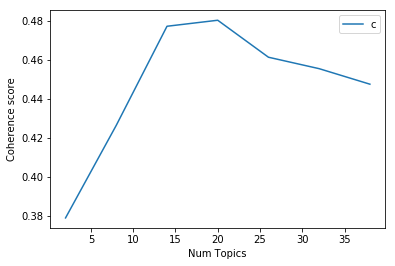

In [25]:
# Show graph
#This plot will show, coherence_values for each topics.
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [26]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3791
Num Topics = 8  has Coherence Value of 0.4265
Num Topics = 14  has Coherence Value of 0.4772
Num Topics = 20  has Coherence Value of 0.4803
Num Topics = 26  has Coherence Value of 0.4614
Num Topics = 32  has Coherence Value of 0.4555
Num Topics = 38  has Coherence Value of 0.4476


** As we can see from the graph, considering 14 topics is pretty good idea**

In [27]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.052*"really" + 0.051*"well" + 0.043*"knowledge" + 0.033*"high" + '
  '0.022*"term" + 0.022*"experience" + 0.021*"also" + 0.019*"graduate" + '
  '0.018*"working" + 0.018*"trainee"'),
 (1,
  '0.178*"good_company" + 0.058*"friendly" + 0.033*"love" + 0.027*"people" + '
  '0.026*"campus" + 0.024*"great_company" + 0.018*"systematic" + '
  '0.014*"centric" + 0.013*"suitable" + 0.012*"plan"'),
 (2,
  '0.090*"great_place" + 0.087*"work" + 0.060*"get" + 0.036*"learn" + '
  '0.025*"day" + 0.023*"overall" + 0.022*"something" + 0.021*"project" + '
  '0.017*"new" + 0.014*"complete"'),
 (3,
  '0.058*"team" + 0.042*"year" + 0.033*"growth" + 0.031*"great" + '
  '0.028*"opportunity" + 0.021*"many" + 0.020*"role" + 0.017*"make" + '
  '0.017*"support" + 0.017*"great_company"'),
 (4,
  '0.107*"engineer" + 0.078*"lot" + 0.037*"grow" + 0.037*"technical" + '
  '0.036*"flexibility" + 0.029*"give" + 0.024*"colleague" + '
  '0.022*"good_salary" + 0.018*"network" + 0.016*"lead"'),
 (5,
  '0.152*"good_wo

In [28]:
#This function will get the keywords, which has dominated more to build the topic.
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=clean_review_content):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
#         print(row)
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=clean_review_content)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show


In [29]:
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.3180,"good, work, company, learn, management, nice, ...",good good work life good perk goody
1,1,8.0,0.3558,"learning, job, work_culture, opportunity, skil...",physical design engineer work life balance goo...
2,2,13.0,0.5963,"employee, benefit, manager, senior, great, hea...",great place ro work great place work collabora...
3,3,1.0,0.3523,"good_company, friendly, love, people, campus, ...",friendly working culture help person grow indi...
4,4,0.0,0.3719,"really, well, knowledge, high, term, experienc...",working style flexibility opportunity learn we...
5,5,6.0,0.5424,"good, work, company, learn, management, nice, ...",good work flexible timing several site enterta...
6,6,2.0,0.5910,"great_place, work, get, learn, day, overall, s...",overall great place work great culture great p...
7,7,5.0,0.6285,"good_work, culture, life_balance, great_work, ...",great work life balance doesnt work great work...
8,8,10.0,0.2530,"work_life, balance, career, start, balance_goo...",great place work great learning exp work life ...
9,9,4.0,0.4868,"engineer, lot, grow, technical, flexibility, g...",knowledgeable peer competitive sometime redund...


In [30]:
# df_dominant_topic [df_dominant_topic == 0.0]
# df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == 1.0]

In [31]:
#Here I am droping review column, because in the next cell I am merging df_dominant_topic and df2
#df_dominant_topic, this aleady has preprocessed text of reviews
df2 = df.drop(['review'],axis=1)

In [32]:
df_new = pd.merge(df_dominant_topic,df2, on='Document_No')

In [33]:
df_new.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,company_code,company_name
0,0,6.0,0.3180,"good, work, company, learn, management, nice, ...",good good work life good perk goody,1,Intel
1,1,8.0,0.3558,"learning, job, work_culture, opportunity, skil...",physical design engineer work life balance goo...,1,Intel
2,2,13.0,0.5963,"employee, benefit, manager, senior, great, hea...",great place ro work great place work collabora...,1,Intel
3,3,1.0,0.3523,"good_company, friendly, love, people, campus, ...",friendly working culture help person grow indi...,1,Intel
4,4,0.0,0.3719,"really, well, knowledge, high, term, experienc...",working style flexibility opportunity learn we...,1,Intel


In [39]:
#The 14 topics
Topics = {
    'knowledge':0.0,
    'good company':1.0,
    'great place':2.0,
    'opportunity':3.0,
    'flexibility':4.0,
    'life balance':5.0,
    'great environment':6.0,
    'learning':7.0,
    'great brand':8.0,
    'good experience':9.0,
    'career':10.0,
    'supportive':11.0,
    'excellent service':12.0,
    'employee benefit':13.0
}

#A function to select
def select_topic(topic):
    if topic in Topics:
        result = df_new.loc[df_new['Dominant_Topic'] == Topics[topic]]        
    return result
    

#A function to display review 
def display_reviews(topic):
    result = select_topic(topic)
    for i in range(len(result)):
        print("Company Name :",str(result.company_name.iloc[i]))
        print("Review :",str(result.Text.iloc[i]))
        print("\n")
        
    

In [41]:
#Function call to display reviews
display_reviews('good experience')

Company Name : Intel
Review : awesome place work great opportunity hand experience intern freedom suggest possible solution product


Company Name : Google
Review : software engineer awesome place work learn


Company Name : Google
Review : good work good benefit great people


Company Name : Google
Review : software engineer intern google amazing learning environment good food


Company Name : Google
Review : great working good foodwork life balancegreat people


Company Name : Google
Review : great company great quality work challenging work environment


Company Name : Microsoft
Review : life microsoft idc good work life balance good married people


Company Name : Microsoft
Review : awesom good work life balancehumble peer


Company Name : Microsoft
Review : simply amazing food work culture employee satisfaction


Company Name : Microsoft
Review : director solution cloud vision senior leader business direction


Company Name : Microsoft
Review : great experience great work culture 